In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
from python.functions import *
from python.models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-01-26 16:58:47.056744: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-26 16:58:47.078965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-26 16:58:47.079139: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-26 16:58:47.080413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-26 16:58:47.081940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-26 16:58:47.082137: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [3]:
stream = "gd1_tail"

In [4]:
df, file = load_file(stream = stream, percent_bkg = 100)

In [5]:
# plt.figure(figsize=(3,3),dpi=150)
# hist = plt.hist2d(df.α, df.δ, bins=20)
# plt.xlabel(r'$\alpha$ [\textdegree]');
# plt.ylabel(r'$\delta$ [\textdegree]');

In [6]:
# # Get indices for hotspot bin to exclude
# i, j = np.unravel_index(hist[0].argmax(), hist[0].shape)

# # Exclude this bin based on bin edges 
# df2 = df[(df.α < hist[1][i]) | (df.α > hist[1][i+1]) | 
#          (df.δ < hist[1][j]) | (df.δ > hist[1][j+1])]

# print("{:.1f}% of the dataset remains.".format(100*len(df2)/len(df)))

# # Redefine dataframe
# df = df2

### Prepare datasets for training

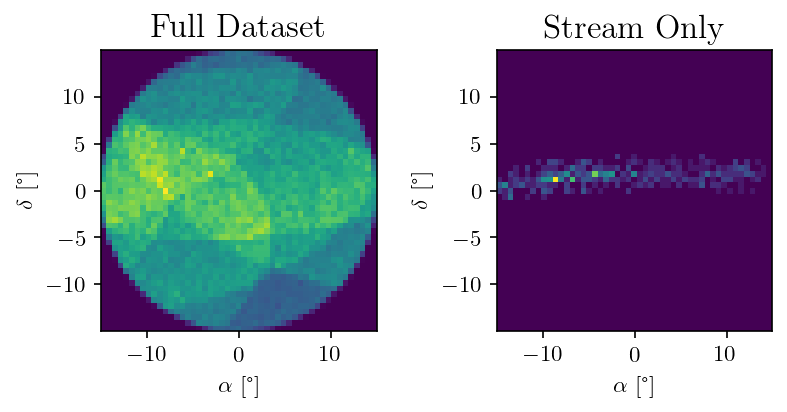

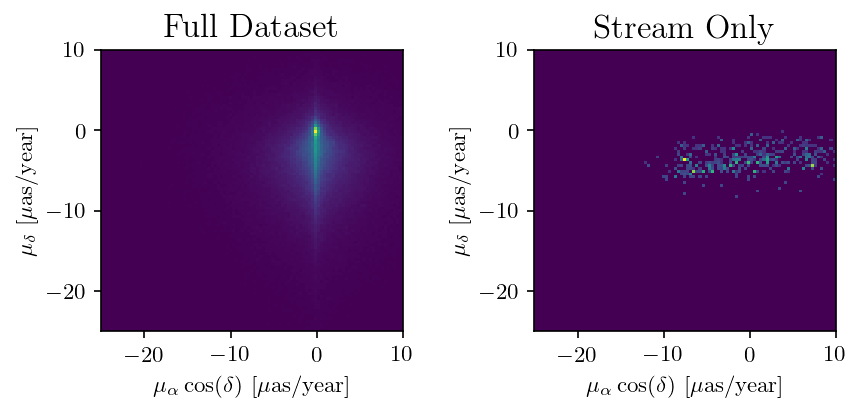

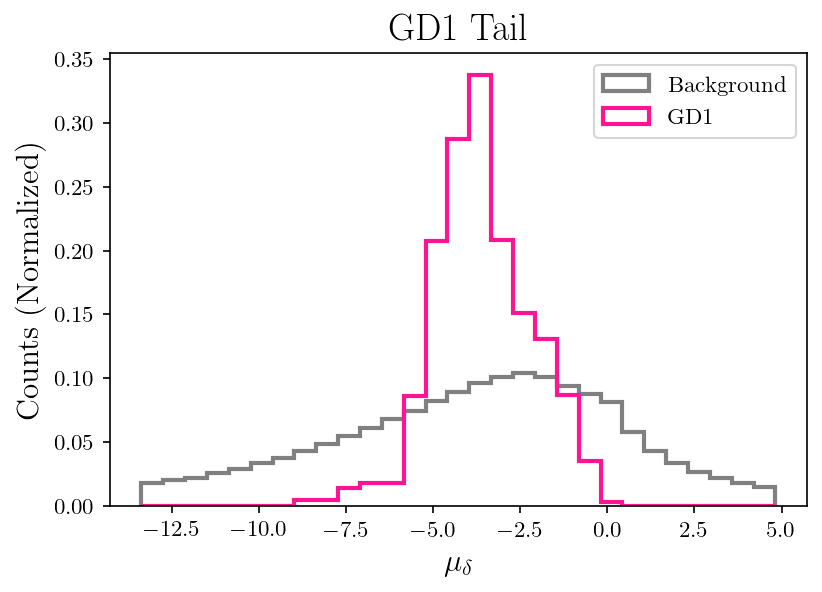

In [7]:
visualize_stream(df)

Sideband region: [-7.0,-3.0]
Signal region: [-6.0,-3.1]
Total counts: SR = 613,810, SB = 181,912


/clusterfs/ml4hep/mpettee/GaiaCWoLa/notebooks/../python/functions.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)
No handles with labels found to put in legend.


Signal region has 1,565 stream and 612,245 bkg events (0.26%).
Sideband region has 94 stream and 181,818 bkg events (0.05%).
f_sig = 4.9X f_sideband.


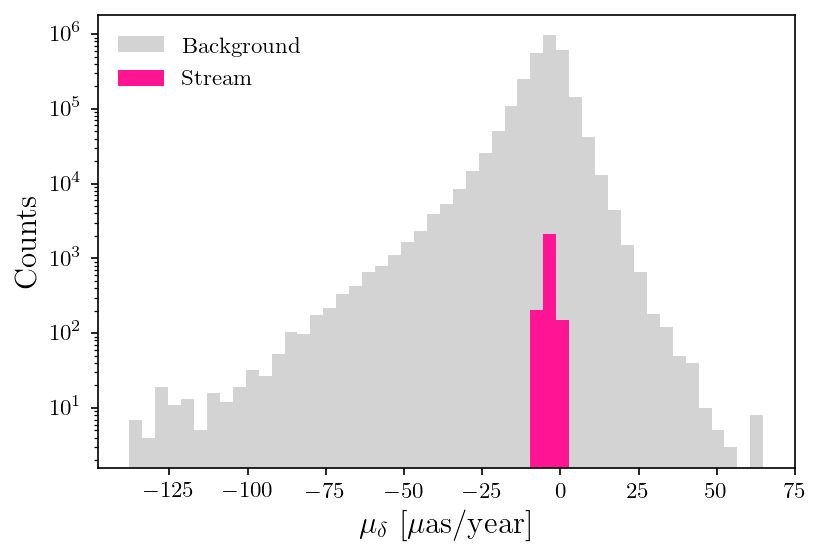

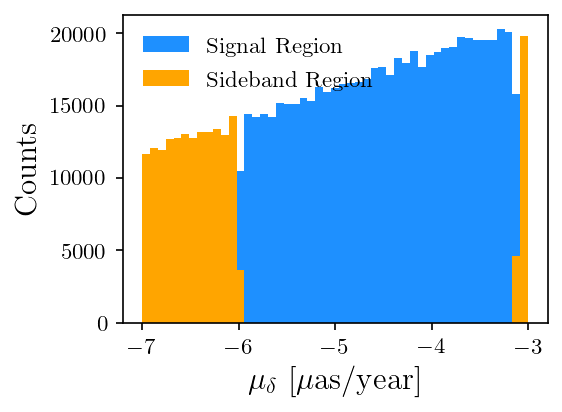

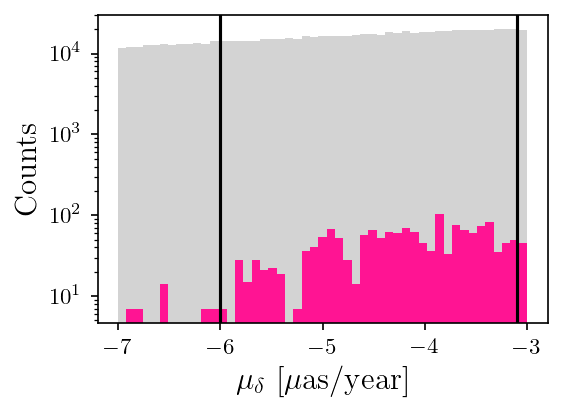

In [8]:
df = signal_sideband(df, stream = stream)

# Train

In [9]:
tf.keras.backend.clear_session()

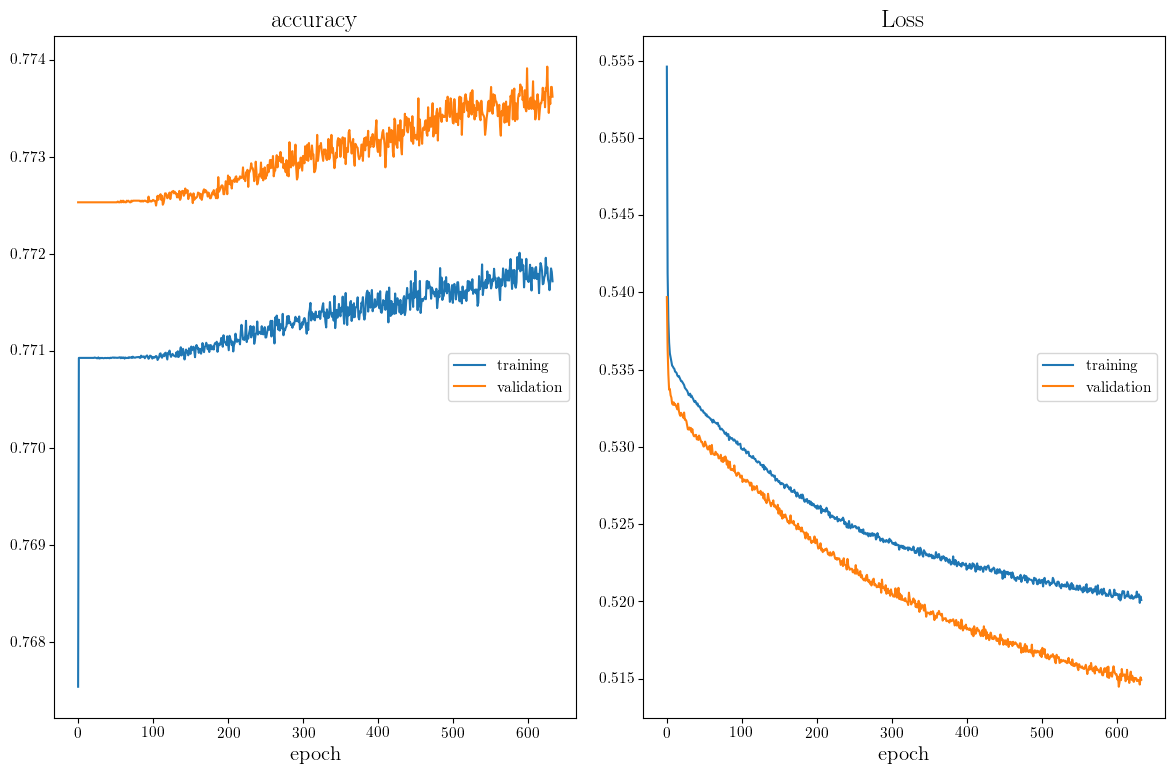

accuracy
	training         	 (min:    0.768, max:    0.772, cur:    0.772)
	validation       	 (min:    0.772, max:    0.774, cur:    0.774)
Loss
	training         	 (min:    0.520, max:    0.555, cur:    0.520)
	validation       	 (min:    0.514, max:    0.540, cur:    0.515)
56/56 [==============================] - 0s 8ms/step - loss: 0.5201 - accuracy: 0.7717 - val_loss: 0.5149 - val_accuracy: 0.7736
Best losses: [0.5199050903320312]
Loading weights from best loop, i.e. loop #0.
AUC: 0.636
Maximum purity of 12.7% at 0.51%
Top 10 stars: Purity = 10.0% 
Top 20 stars: Purity = 10.0% 
Top 50 stars: Purity = 26.0% 
Top 100 stars: Purity = 30.0% 


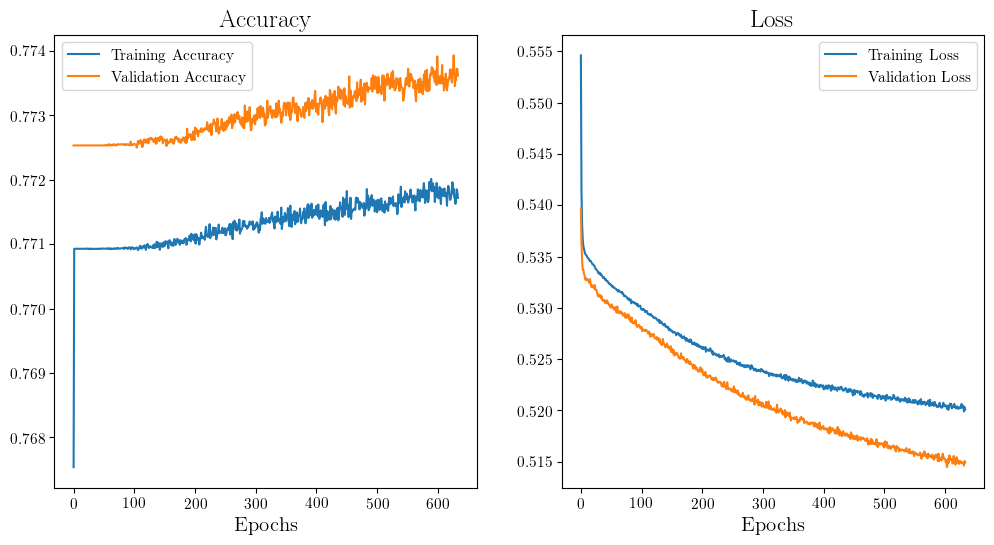

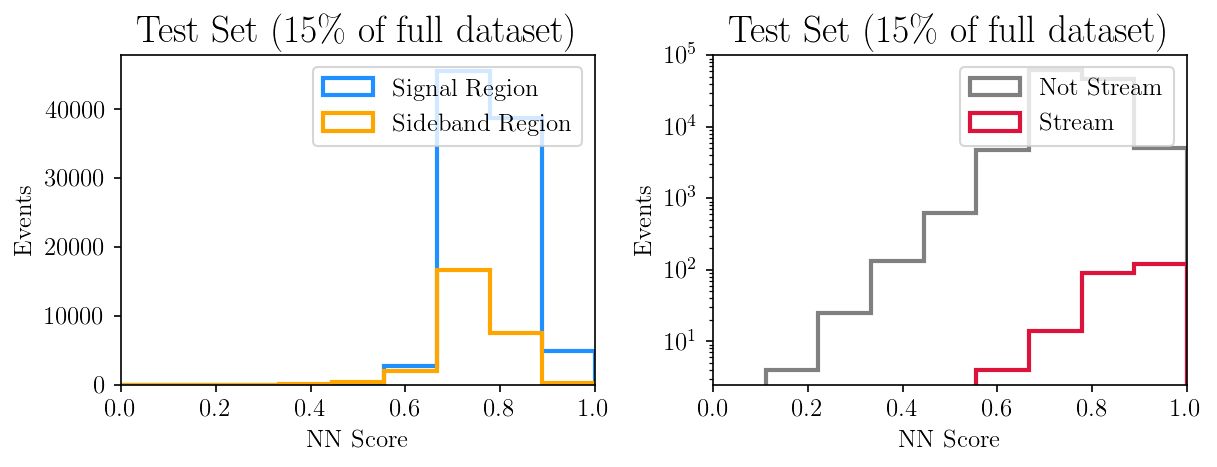

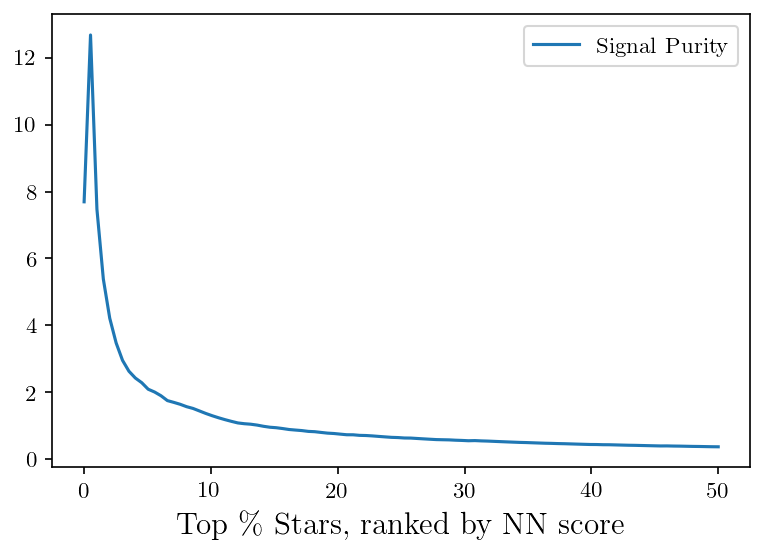

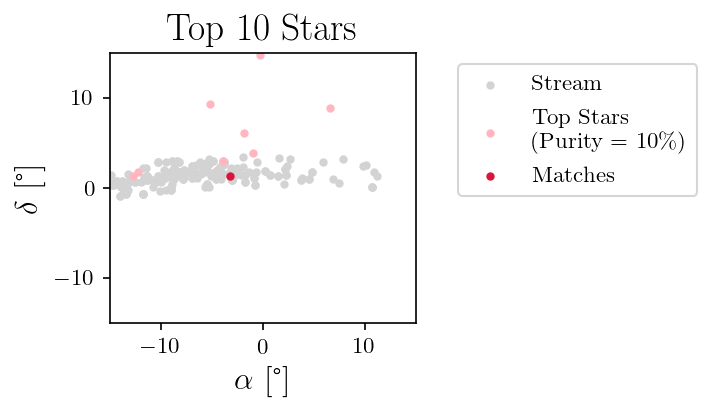

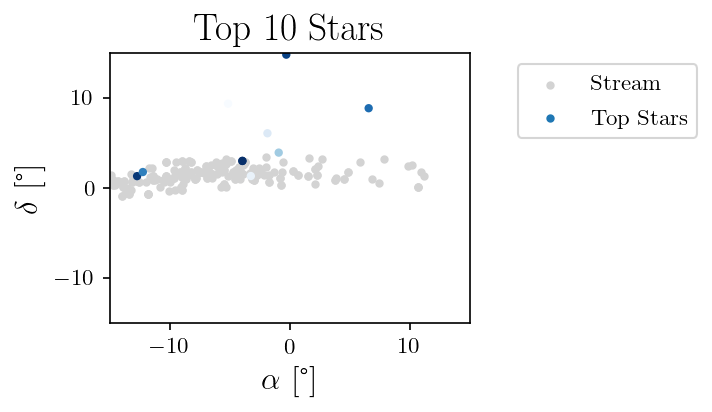

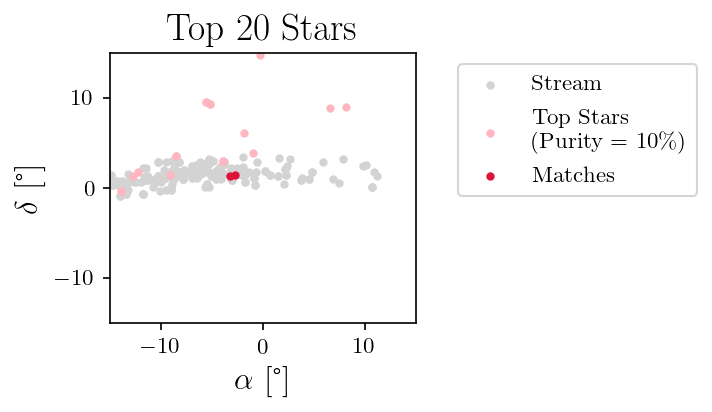

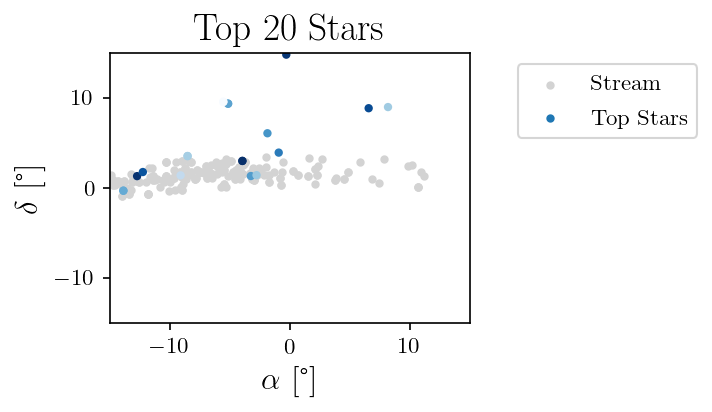

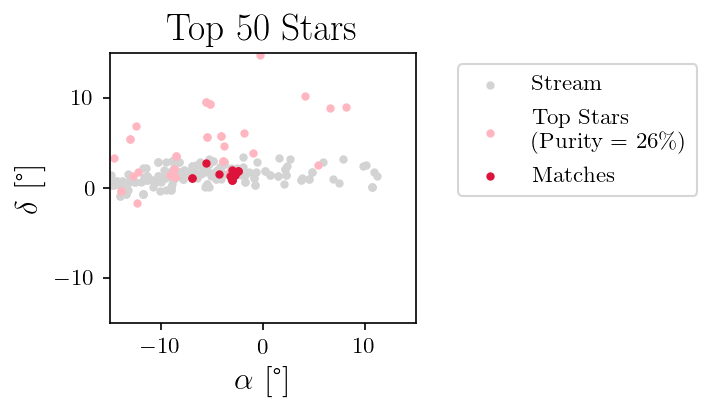

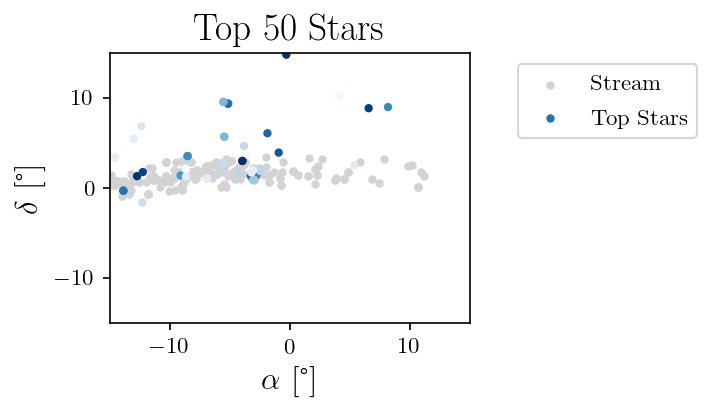

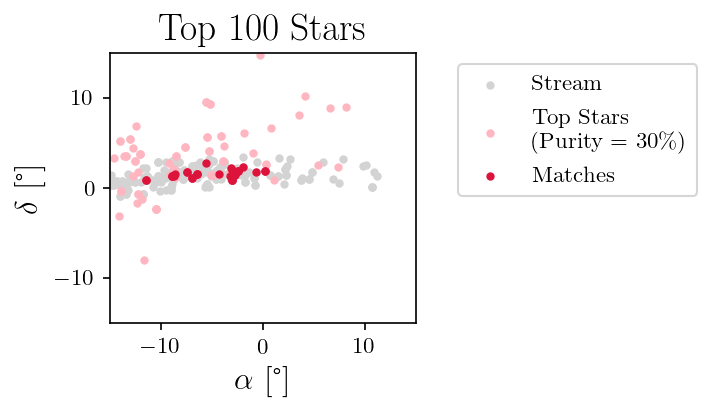

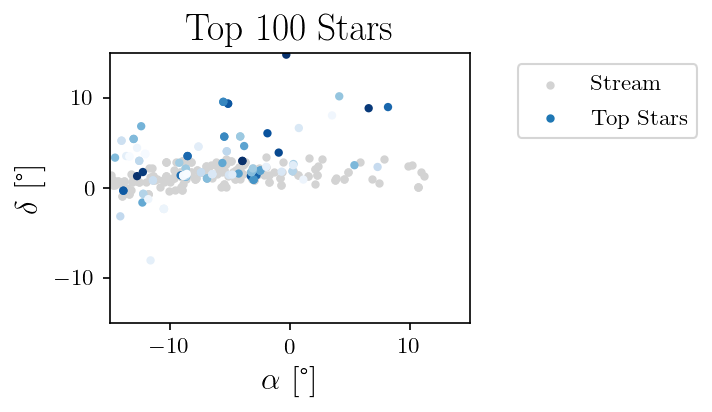

In [10]:
test = train(df, 
      n_folds = 1, 
      best_of_n_loops = 1,
      layer_size = 128, 
      batch_size = 10000, 
      dropout = 0.2, 
      epochs = 2000, 
      patience = 30)